Trying another tutorial using this [approach](https://www.kaggle.com/zakarii/dna-sequence-classification-cnn-gru)

In [1]:
import pandas as pd
import numpy as np
import os

import joblib

from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras

In [73]:
!ls ../data

sars_unaligned_variants.txt variants.aln4.fas.txt


In [72]:
#load the dataset
seq_data_not_aligned = pd.read_table('../data/sars_variants.fas.aln.fas.txt')

FileNotFoundError: [Errno 2] No such file or directory: '../data/sars_variants.fas.aln.fas.txt'

In [48]:
seq_data_not_aligned.head()

,Seq_Id,sequence,Variant_Id
0,alpha/hCoV19/England/PHEC3P0B3PFA/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
1,alpha/hCoV19/England/NORW30C9D91/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
2,alpha/hCoV19/England/PHECY304YD99/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
3,alpha/hCoV19/England/MILK1F305AC/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
4,alpha/hCoV19/England/MILK1F339BC/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha


In [49]:
seq_data_not_aligned.Variant_Id.value_counts()

beta       1475
omicron    1346
delta      1341
alpha      1164
gamma      1102
Name: Variant_Id, dtype: int64

In [50]:
seq_data = seq_data_not_aligned.copy()

In [51]:
seq_data.head()

,Seq_Id,sequence,Variant_Id
0,alpha/hCoV19/England/PHEC3P0B3PFA/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
1,alpha/hCoV19/England/NORW30C9D91/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
2,alpha/hCoV19/England/PHECY304YD99/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
3,alpha/hCoV19/England/MILK1F305AC/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha
4,alpha/hCoV19/England/MILK1F339BC/2021,atgtttgtttttcttgttttattgccactagtctctagtcagtgtg...,alpha


In [52]:
#map the variants to numeric form
variant = {"gamma" : 0, "delta" : 1, "beta":2, "alpha":3, "omicron":4}
seq_data["Variant_Id"] = seq_data["Variant_Id"].map(variant)

#drop  seq_id column and have the nucleotides in uppercase
seq_data = seq_data.drop(["Seq_Id"], axis=1)
seq_data['sequence'] = seq_data['sequence'].str.upper()

In [53]:
seq_data.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3


In [54]:
#Check characters in the seqeunce column
ntds = []
for i in seq_data['sequence']:
    for seq in i:

        ntd = seq.strip()
        ntds.append(ntd)
    
char = list(set(ntds))

In [55]:
char

['A', 'K', 'C', 'G', 'T', 'R', 'N', 'M', 'S', 'W', 'Y']

In [35]:
a = [0] * len(char)
a

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
for x in range(len(char)):
    print(x)

0
1
2
3
4
5
6
7
8
9
10


In [28]:
np.array(11)

array(11)

In [56]:
sequence_data = list(seq_data.loc[:, 'sequence'])

In [57]:
encoded_list = []

def encode_seq(s):
    Encode = {'A':[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'T':[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                'C':[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],'G':[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 
                '-':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'N':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                'K':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'R':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'M' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                'W': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Y' : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'S':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
    return [Encode[x] for x in s]

for i in sequence_data:
    x = encode_seq(i)
    encoded_list.append(x)

X_mine = np.array(encoded_list)
X_mine.shape

/var/folders/xd/_xhxvsqj3px3y07fpzdrncmh0000gn/T/ipykernel_915/3784273683.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_mine = np.array(encoded_list)


(6428,)

In [39]:
encoded_list[1]

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0,

In [58]:
seq_data["Variant_Id"].unique()

array([3, 2, 1, 0, 4])

In [59]:
y_mine = seq_data['Variant_Id']
y_mine.shape

(6428,)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_mine, y_mine, random_state = 42, stratify = y_mine)
from keras import utils as np_utils

y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [61]:
params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32], 
    'dropout': [0.1, 0.2, 0.5]
}

gru_model = Sequential()

#Layer 1 - feature extraction
#Performs dimension reduction

gru_model.add(Conv1D(filters = 27, kernel_size = (4), activation = 'relu', input_shape = (6428, 11))) #ensure you change the shape
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Dropout(0.2))
gru_model.add(Conv1D(filters = 14, kernel_size = (2), activation = 'relu', padding = 'same'))


gru_model.add(Bidirectional(GRU(128, activation = 'relu')))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
gru_model.add(Dense(5, activation = 'softmax'))

#gru_model.add(Flatten())

gru_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )
history = gru_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=15)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [63]:
# Plot the loss and accuracy curves for training and validation 

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'history' is not defined

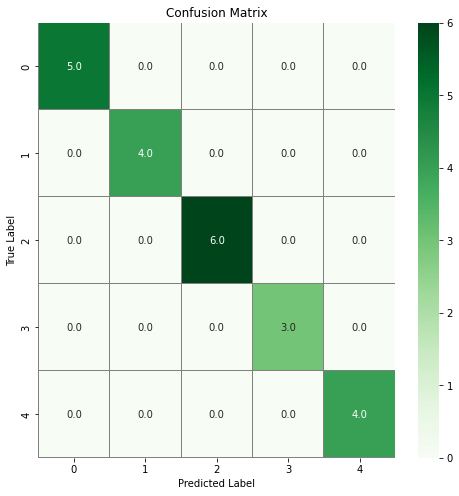

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = gru_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_test,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()